In [1]:
# Librerías principales
!pip install pandas numpy matplotlib scikit-learn scipy

# Librerías de Hugging Face Transformers
!pip install transformers

# Librerías adicionales para gráficos 3D
!pip install mpl_toolkits


ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
import zipfile
import glob
from sklearn.metrics import f1_score

from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertModel, BertConfig

import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch

In [3]:
#load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', output_hidden_states=True)
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 1-token plural
pd.set_option('display.max_rows', None)

noun_list = pd.read_csv("spanish_noun_list.csv")
noun_list= noun_list[['whole_word', 'root', 'affix']]

#filter out 2-token lemmas
print("single token")
idx_drop = []
for i in range(len(noun_list)):
    root = noun_list.iloc[i]['root']
    tokenized_root = tokenizer(root)
    if len(tokenized_root['input_ids']) > 3:
        print(root,tokenized_root)
        idx_drop.append(i)
noun_list = noun_list.drop(idx_drop).reset_index()

noun_list_s = noun_list[noun_list['affix'] == 's']
noun_list_es = noun_list[noun_list['affix'] == 'es']

# 2-token morph
print("morph token")
split_noun_list2 = pd.read_csv("not_stored_pl.csv")

idx_drop = []
for i in range(len(split_noun_list2)):
    root = split_noun_list2.iloc[i]['root']
    tokenized_root = tokenizer(root)
    if len(tokenized_root['input_ids']) > 3:
        print(tokenized_root)
        idx_drop.append(i)
split_noun_list2 = split_noun_list2.drop(idx_drop).reset_index()

#non morph
print("non-morph token")
non_morph_2tok = pd.read_csv("non_morph_2tok_noun_list.csv")
idx_drop = []
for i in range(len(non_morph_2tok)):
    root = non_morph_2tok.iloc[i]['root']
    tokenized_root = tokenizer(root)
    if len(tokenized_root['input_ids']) > 4:
        print(tokenized_root)
        idx_drop.append(i)
non_morph_2tok = non_morph_2tok.drop(idx_drop).reset_index()

single token
divisa {'input_ids': [4, 8408, 30932, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
inmigrante {'input_ids': [4, 7442, 19351, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
accionista {'input_ids': [4, 13994, 1629, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
frita {'input_ids': [4, 11048, 1095, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
firmante {'input_ids': [4, 6789, 30935, 1066, 5], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}
turista {'input_ids': [4, 3974, 1629, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
litro {'input_ids': [4, 26011, 1050, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
poblador {'input_ids': [4, 17845, 30936, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
interlocutor {'input_ids': [4, 14541, 1193, 5], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}
dese

In [6]:
# get embeddings

embeddings_sing = {} #singular
embeddings_pl = {} #plural
embeddings_comp = {} #artificially tokenized pl
for word in range(len(noun_list_es)):

    plural = noun_list_es.iloc[word]['whole_word']
    singular = noun_list_es.iloc[word]['root']
    lemma = noun_list_es.iloc[word]['root']
    inputs_sg = tokenizer(singular, return_tensors="pt")
    inputs_pl = tokenizer(plural, return_tensors="pt")
    computed_input_ids = torch.tensor([[inputs_sg['input_ids'][0][0], inputs_sg['input_ids'][0][1], 1019, inputs_sg['input_ids'][0][2]]])
    inputs_computed = {'input_ids': computed_input_ids,
                               'token_type_ids': torch.tensor([[0,0,0,0]]),
                               'attention_mask': torch.tensor([[1,1,1,1]])}
    with torch.no_grad():
        outputs_sg = model(**inputs_sg)
        outputs_pl = model(**inputs_pl)
        outputs_computed = model(**inputs_computed)
    hidden_states_sg = outputs_sg[2]
    embedding_output_sg = hidden_states_sg[0]
    attention_hidden_states_sg = hidden_states_sg[1:]
    last_4_layers_sg = attention_hidden_states_sg[-4:]
    last_4_layers_sg = [x[0][0] for x in last_4_layers_sg]
    context_embed_sg = torch.stack(last_4_layers_sg).mean(dim=0)

    hidden_states_pl = outputs_pl[2]
    embedding_output_pl = hidden_states_pl[0]
    attention_hidden_states_pl = hidden_states_pl[1:]
    last_4_layers_pl = attention_hidden_states_pl[-4:]
    last_4_layers_pl = [x[0][0] for x in last_4_layers_pl]
    context_embed_pl = torch.stack(last_4_layers_pl).mean(dim=0)

    hidden_states_computed = outputs_computed[2]
    embedding_output_computed = hidden_states_computed[0]
    attention_hidden_states_computed = hidden_states_computed[1:]
    last_4_layers_computed = attention_hidden_states_computed[-4:]
    last_4_layers_computed = [x[0][0] for x in last_4_layers_computed]
    context_embed_computed = torch.stack(last_4_layers_computed).mean(dim=0)


    embeddings_sing[singular] = context_embed_sg
    embeddings_pl[plural] = context_embed_pl
    embeddings_comp[singular+'+es'] = context_embed_computed

for word in range(len(noun_list_s)):

    plural = noun_list_s.iloc[word]['whole_word']
    singular = noun_list_s.iloc[word]['root']
    lemma = noun_list_s.iloc[word]['root']
    inputs_sg = tokenizer(singular, return_tensors="pt")
    inputs_pl = tokenizer(plural, return_tensors="pt")
    computed_input_ids = torch.tensor([[inputs_sg['input_ids'][0][0], inputs_sg['input_ids'][0][1], 30934, inputs_sg['input_ids'][0][2]]])
    inputs_computed = {'input_ids': computed_input_ids,
                               'token_type_ids': torch.tensor([[0,0,0,0]]),
                               'attention_mask': torch.tensor([[1,1,1,1]])}
    with torch.no_grad():
        outputs_sg = model(**inputs_sg)
        outputs_pl = model(**inputs_pl)
        outputs_computed = model(**inputs_computed)
    hidden_states_sg = outputs_sg[2]
    embedding_output_sg = hidden_states_sg[0]
    attention_hidden_states_sg = hidden_states_sg[1:]
    last_4_layers_sg = attention_hidden_states_sg[-4:]
    last_4_layers_sg = [x[0][0] for x in last_4_layers_sg]
    context_embed_sg = torch.stack(last_4_layers_sg).mean(dim=0)

    hidden_states_pl = outputs_pl[2]
    embedding_output_pl = hidden_states_pl[0]
    attention_hidden_states_pl = hidden_states_pl[1:]
    last_4_layers_pl = attention_hidden_states_pl[-4:]
    last_4_layers_pl = [x[0][0] for x in last_4_layers_pl]
    context_embed_pl = torch.stack(last_4_layers_pl).mean(dim=0)

    hidden_states_computed = outputs_computed[2]
    embedding_output_computed = hidden_states_computed[0]
    attention_hidden_states_computed = hidden_states_computed[1:]
    last_4_layers_computed = attention_hidden_states_computed[-4:]
    last_4_layers_computed = [x[0][0] for x in last_4_layers_computed]
    context_embed_computed = torch.stack(last_4_layers_computed).mean(dim=0)


    embeddings_sing[singular] = context_embed_sg
    embeddings_pl[plural] = context_embed_pl
    embeddings_comp[singular+'+s'] = context_embed_computed

In [7]:
#two token morph
embeddings_test = {}
for word in range(len(split_noun_list2)):
    plural = split_noun_list2.iloc[word]['whole_word']
    singular = split_noun_list2.iloc[word]['root']
    #add singular?
    inputs_pl = tokenizer(plural, return_tensors="pt")

    with torch.no_grad():
        outputs_pl = model(**inputs_pl)

    hidden_states_pl = outputs_pl[2]
    embedding_output_pl = hidden_states_pl[0]
    attention_hidden_states_pl = hidden_states_pl[1:]
    last_4_layers_pl = attention_hidden_states_pl[-4:]
    last_4_layers_pl = [x[0][0] for x in last_4_layers_pl]
    context_embed_pl = torch.stack(last_4_layers_pl).mean(dim=0)

    embeddings_test[plural] = context_embed_pl

#two token non morph
embeddings_non_morph = {}
for word in range(len(non_morph_2tok)):
    plural = non_morph_2tok.iloc[word]['whole_word']
    singular = non_morph_2tok.iloc[word]['root']
    inputs_pl = tokenizer(plural, return_tensors="pt")

    with torch.no_grad():
        outputs_pl = model(**inputs_pl)

    hidden_states_pl = outputs_pl[2]
    embedding_output_pl = hidden_states_pl[0]
    attention_hidden_states_pl = hidden_states_pl[1:]
    last_4_layers_pl = attention_hidden_states_pl[-4:]
    last_4_layers_pl = [x[0][0] for x in last_4_layers_pl]
    context_embed_pl = torch.stack(last_4_layers_pl).mean(dim=0)

    embeddings_non_morph[plural] = context_embed_pl

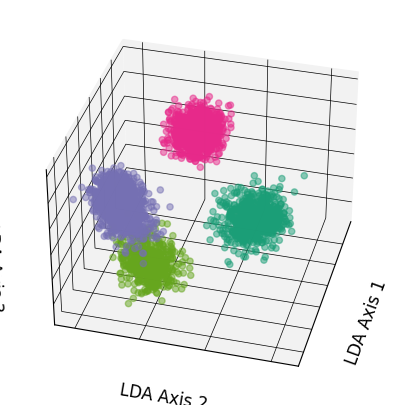

In [ ]:
#fit LDA
# Ensure singular embeddings are properly stacked
sing_array = np.stack(list(embeddings_sing.values()))  # Stack embeddings_sing values into an array
sing_labels = np.array([0] * sing_array.shape[0])  # Create labels for the singular embeddings

pl_array = np.stack(list(embeddings_pl.values()))  # Stack embeddings_pl values into an array
pl_labels = np.array([1] * pl_array.shape[0])  # Create labels for the plural embeddings

comp_array = np.stack(list(embeddings_comp.values()))  # Stack embeddings_comp values into an array
comp_labels = np.array([2] * comp_array.shape[0])  # Create labels for the computed embeddings

morph_array = np.stack(list(embeddings_test.values()))  # Stack embeddings_test values into an array
morph_labels = np.array([3] * morph_array.shape[0])  # Create labels for the morph embeddings

non_morph_array = np.stack(list(embeddings_non_morph.values()))  # Stack embeddings_non_morph values into an array
non_morph_labels = np.array([4] * non_morph_array.shape[0])  # Create labels for the non-morph embeddings


all_array = np.concatenate([pl_array, comp_array, morph_array, non_morph_array])
all_label = np.concatenate([pl_labels, comp_labels, morph_labels, non_morph_labels])

lda = LinearDiscriminantAnalysis()
lda.fit(all_array, all_label)
# Shape: (n_dims, n_classes-1)
lda_axes = lda.scalings_

##generate embeddings for plotting
sing_embeddings_list = []
for k, v in embeddings_sing.items():
    sing_embeddings_list.append(np.array(v))
sing_embeddings_list = np.array(sing_embeddings_list)
pl_embeddings_list = []
for k, v in embeddings_pl.items():
    pl_embeddings_list.append(np.array(v))
pl_embeddings_list = np.array(pl_embeddings_list)
computed_embeddings_list = []
for k, v in embeddings_comp.items():
    computed_embeddings_list.append(np.array(v))
computed_embeddings_list = np.array(computed_embeddings_list)
embeddings_test_list = []
for k, v in embeddings_test.items():
    embeddings_test_list.append(np.array(v))
embeddings_test_list = np.array(embeddings_test_list)
embeddings_non_morph_list = []
for k, v in embeddings_non_morph.items():
    embeddings_non_morph_list.append(np.array(v))
embeddings_non_morph_list = np.array(embeddings_non_morph_list)

#3d plot
fig = plt.figure(figsize=(5,5))

plt.rcParams.update({'font.size': 12})

ax = fig.add_subplot(projection='3d')
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
# ax.axes.zaxis.set_ticklabels([])
ax.scatter(np.matmul(computed_embeddings_list,  lda_axes[:,0]), np.matmul(computed_embeddings_list,  lda_axes[:,1]), np.matmul(computed_embeddings_list,  lda_axes[:,2]), c='#7570b3', label = 'artificial', alpha=0.5)
ax.scatter(np.matmul(pl_embeddings_list,  lda_axes[:,0]), np.matmul(pl_embeddings_list,  lda_axes[:,1]), np.matmul(pl_embeddings_list,  lda_axes[:,2]), c='#e7298a', label = 'one-token plural', alpha=0.5)
ax.scatter(np.matmul(embeddings_non_morph_list,  lda_axes[:,0]), np.matmul(embeddings_non_morph_list,  lda_axes[:,1]), np.matmul(embeddings_non_morph_list,  lda_axes[:,2]), c='#1b9e77', label = 'non-morph', alpha=0.5)
ax.scatter(np.matmul(embeddings_test_list,  lda_axes[:,0]), np.matmul(embeddings_test_list,  lda_axes[:,1]), np.matmul(embeddings_test_list,  lda_axes[:,2]), c='#66a61e', label = 'morph', alpha=0.5)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
ax.set_xlabel('LDA Axis 1')
ax.set_ylabel('LDA Axis 2')
ax.set_zlabel('LDA Axis 3')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)


for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = (100, 100, 100)
    axis._axinfo['grid']['linewidth'] = 0.5
    axis._axinfo['grid']['linestyle'] = "-"
    axis._axinfo['grid']['color'] = (0, 0, 0)
    axis._axinfo['tick']['inward_factor'] = 0.0
    axis._axinfo['tick']['outward_factor'] = 0.0
    axis.set_pane_color((0.95, 0.95, 0.95))

ax.view_init(elev=35, azim=15)

Text(0, 0.5, 'Density')

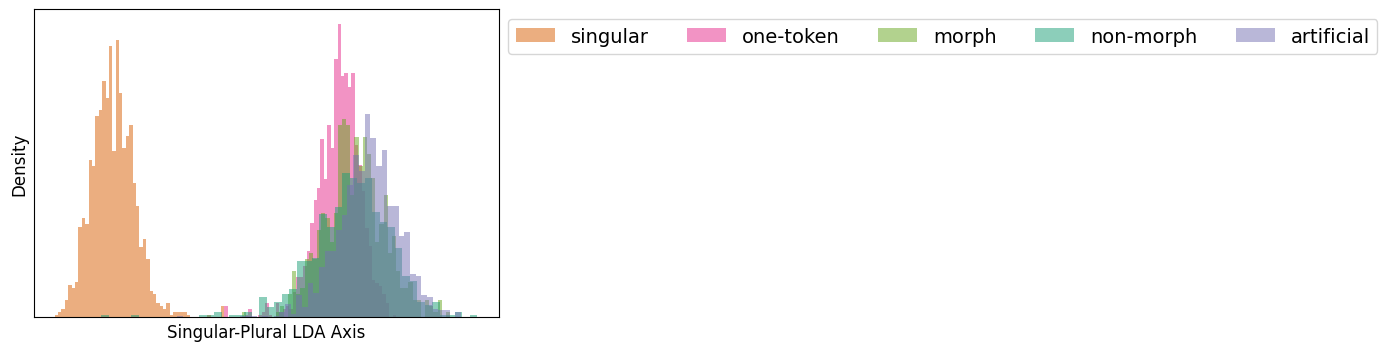

In [ ]:
# LDA histogram

sing_labels = np.array([0]*sing_array.shape[0])
pl_labels = np.array([1]*pl_array.shape[0])

all_array = np.concatenate([sing_array, pl_array])
all_label = np.concatenate([sing_labels, pl_labels])

lda = LinearDiscriminantAnalysis()
lda.fit(all_array, all_label)
# Shape: (n_dims, n_classes-1)
lda_axes = lda.scalings_

sing_embeddings_list = []
for k, v in embeddings_sing.items():
    sing_embeddings_list.append(np.array(v))
sing_embeddings_list = np.array(sing_embeddings_list)

pl_embeddings_list = []
for k, v in embeddings_pl.items():
    pl_embeddings_list.append(np.array(v))
pl_embeddings_list = np.array(pl_embeddings_list)

computed_embeddings_list = []
for k, v in embeddings_comp.items():
    computed_embeddings_list.append(np.array(v))
computed_embeddings_list = np.array(computed_embeddings_list)

embeddings_test_list = []
for k, v in embeddings_test.items():
    embeddings_test_list.append(np.array(v))
embeddings_test_list = np.array(embeddings_test_list)

embeddings_non_morph_list = []
for k, v in embeddings_non_morph.items():
    embeddings_non_morph_list.append(np.array(v))
embeddings_non_morph_list = np.array(embeddings_non_morph_list)

plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(6,4))
plt.hist(np.matmul(sing_embeddings_list,  lda_axes[:,0]), label = 'singular', alpha=0.5, density = True, bins = 50, color='#d95f02')
plt.hist(np.matmul(pl_embeddings_list,  lda_axes[:,0]), label = 'one-token', alpha=0.5, density = True, bins = 50, color='#e7298a')
plt.hist(np.matmul(embeddings_test_list,  lda_axes[:,0]), label = 'morph', alpha=0.5, density = True, bins = 50, color='#66a61e')
plt.hist(np.matmul(embeddings_non_morph_list,  lda_axes[:,0]), label = 'non-morph', alpha=0.5, density = True, bins = 50, color='#1b9e77')
plt.hist(np.matmul(computed_embeddings_list,  lda_axes[:,0]), label = 'artificial', alpha=0.5, density = True, bins = 50, color='#7570b3')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 14}, ncol=5)

plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('Singular-Plural LDA Axis')
plt.ylabel('Density')